In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split

# Load data and preprocess

## Unzip data

In [2]:
import zipfile

with zipfile.ZipFile('data/creditcardfraud.zip', 'r') as zip_ref:
        zip_ref.extractall('data/creditcardfraud')

## Load data

In [3]:
df = pd.read_csv('data/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: xlabel='Class'>

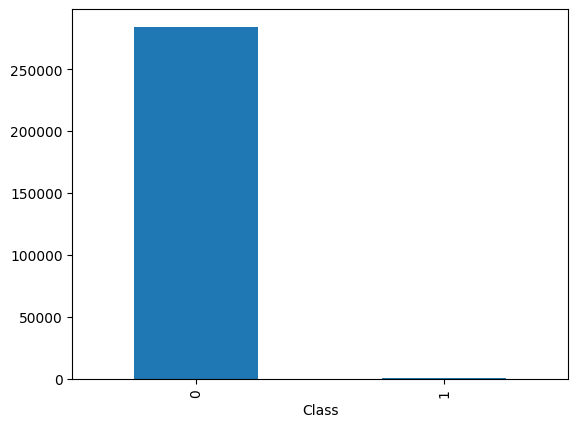

In [4]:
df['Class'].value_counts().plot.bar()

In [12]:
df['Class'].value_counts() * 100/len(df)

Class
0    99.827251
1     0.172749
Name: count, dtype: float64

In [15]:
labels = ['Genuine','Fraud']

fraud_or_not = df['Class'].value_counts().to_list()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values = df['Class'].value_counts(), names=labels, width=350, height=400, color_discrete_sequence=['skyblue','black'], title='Fraud vs Genuine Transactions')
fig.show()

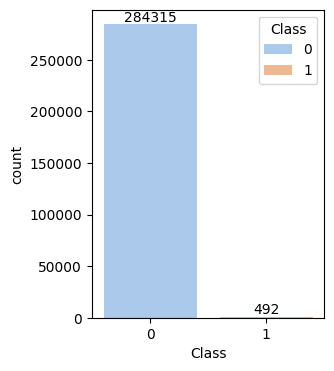

In [17]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class', data=df, palette="pastel", hue='Class')
for i in ax.containers:
    ax.bar_label(i)

## Preprocessing

As data is already scaled for fields other then Time and amount so we will start with outlier check.

In [18]:
# dropping duplicate values

df_dedup = df.copy()

df_dedup.drop_duplicates(inplace=True)
print("*" * 10, 'Duplicate values dropped Successfully', "*" * 10)

********** Duplicate values dropped Successfully **********


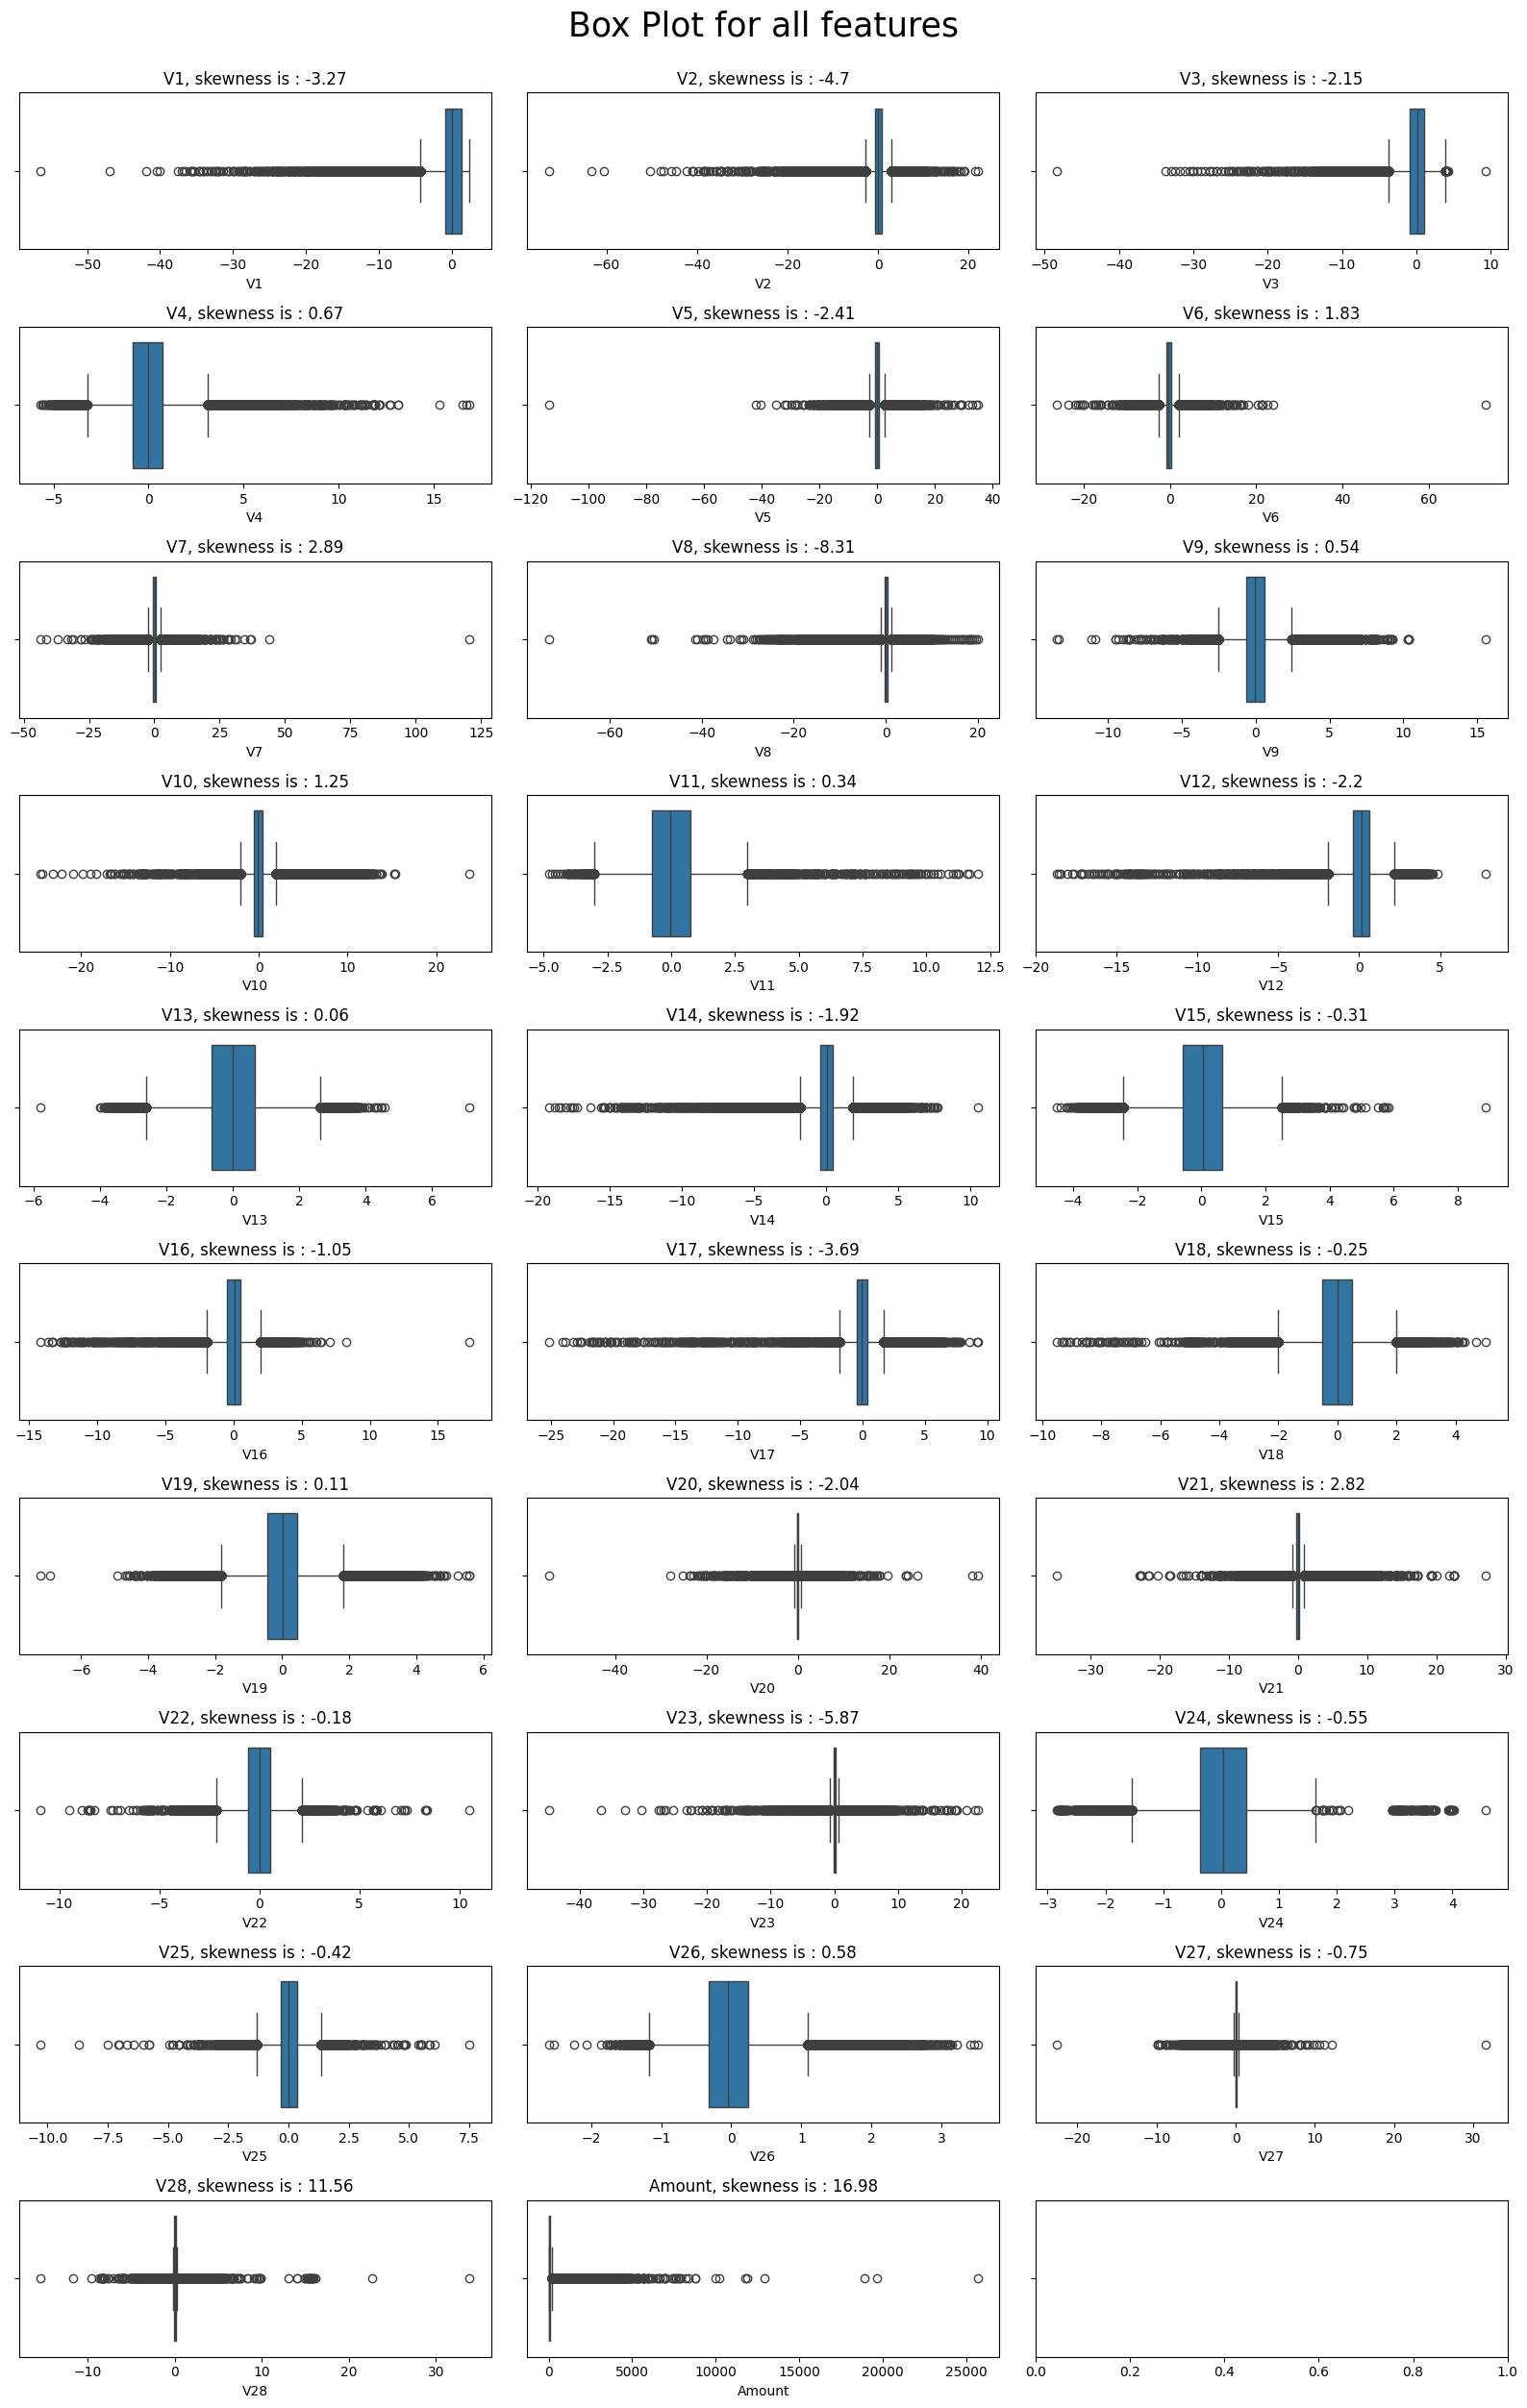

In [20]:
numeric_cols = (list(df_dedup.loc[:, 'V1':'Amount']))

# method for box plot

def my_boxplot(dataset, column_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle, y=1, size=25)

    axs = axs.flatten()
    for i, feature_name in enumerate(column_list):
        sns.boxplot(data = dataset[feature_name], orient='h', ax = axs[i])
        axs[i].set_title(f'{feature_name}, skewness is : {round(dataset[feature_name].skew(axis=0, skipna=True),2)}')


my_boxplot(dataset=df_dedup, column_list=numeric_cols, rows = 10, cols=3, suptitle='Box Plot for all features')
plt.tight_layout()

We have a huge outlier problem here as that is the nature of credit card transactions

In [21]:
# lets apply IQR
from collections import Counter



def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers


Outliers_IQR = IQR_method(df_dedup,1,numeric_cols)
df_out = df_dedup.drop(Outliers_IQR, axis = 0).reset_index(drop=True)



Total number of deleted outliers is: 31685
